# Advanced Model Tuning for AI4I 2020 Preventive Maintenance

This notebook implements advanced model tuning and threshold analysis for the AI4I 2020 preventive maintenance dataset. The workflow includes:

- GridSearchCV-based hyperparameter tuning for Logistic Regression, Decision Tree, and Random Forest models.
- Optimization for F1-score (class 1) for each failure type (TWF, HDF, PWF, OSF, RNF, and overall machine failure).
    - Where TWF = Tool wear failure, HDF = Heat dissipation failure, PWF = Power failure (torque x speed), OSF = Overtrain failure, RNF = Random
- Threshold tuning and precision-recall curve analysis for each model/failure type.
- Summarized and visualized results for clear comparison.

In [1]:
# Imports and Setup for Advanced Model Tuning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the AI4I 2020 dataset
DATA_PATH = './ai4i2020.csv'
df = pd.read_csv(DATA_PATH)

# Display basic info
display(df.head())
display(df.info())

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

None

In [2]:
# Data Cleaning & Feature Engineering (reuse from previous notebook for consistency)

def clean_and_engineer_features(df):
    df = df.copy()
    # Drop 'UDI' and 'Product ID' if present
    df = df.drop(columns=[col for col in ['UDI', 'Product ID'] if col in df.columns], errors='ignore')
    # Encode 'Type' as categorical
    if 'Type' in df.columns:
        df = pd.get_dummies(df, columns=['Type'], drop_first=True)
    # Ensure all failure columns are int
    for col in ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure']:
        if col in df.columns:
            df[col] = df[col].astype(int)
    return df

# Clean and engineer features
df_clean = clean_and_engineer_features(df)
display(df_clean.head())

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,True,False
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,True,False
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,True,False
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,True,False


In [3]:
# Define models, parameter grids, failure types, and utility functions

# Models and parameter grids for GridSearchCV
def get_model_param_grids():
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
    }
    param_grids = {
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        },
        'Decision Tree': {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10]
        }
    }
    return models, param_grids

# Failure types to analyze
FAILURE_TYPES = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Utility: Run GridSearchCV for a model
from sklearn.utils.class_weight import compute_class_weight

def run_grid_search(model, param_grid, X_train, y_train):
    # Use stratified 5-fold, optimize for F1-score (class 1)
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    return grid

# Utility: Find best threshold for F1-score (class 1)
def find_best_threshold(y_true, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx], f1s[best_idx], precisions[best_idx], recalls[best_idx]


=== Failure Type: Machine failure ===
  Model: Logistic Regression


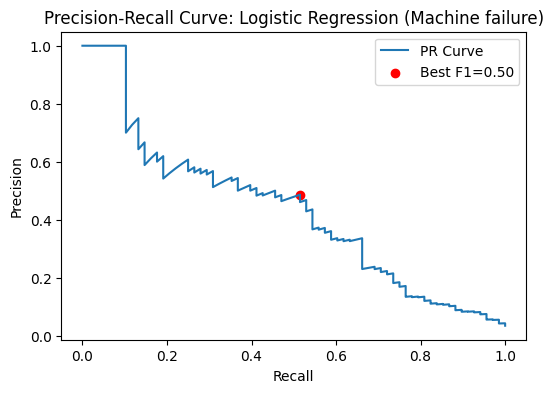

  Model: Decision Tree


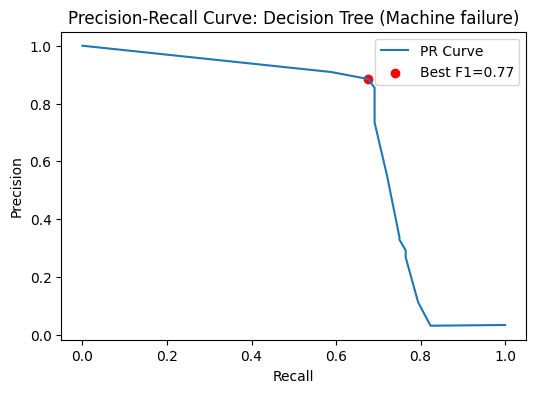

  Model: Random Forest


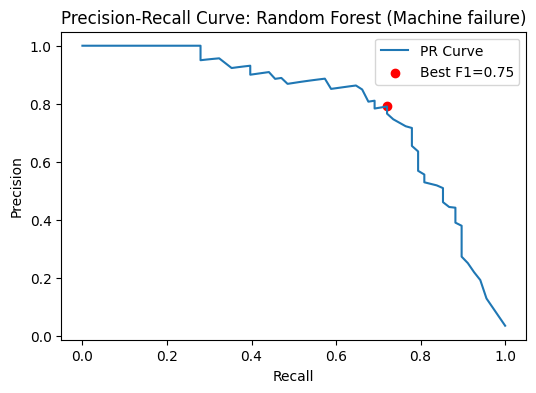


=== Failure Type: TWF ===
  Model: Logistic Regression


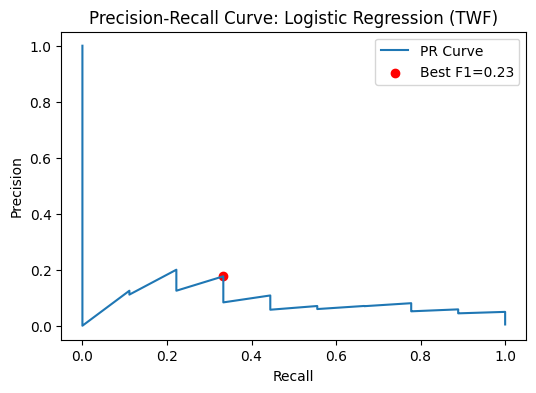

  Model: Decision Tree


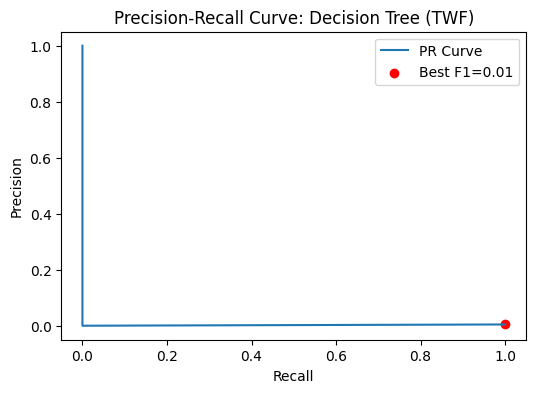

  Model: Random Forest


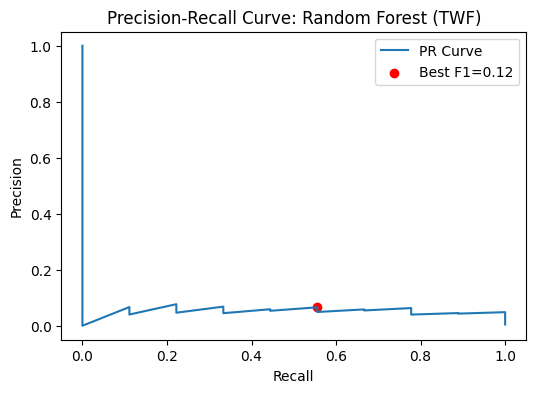


=== Failure Type: HDF ===
  Model: Logistic Regression


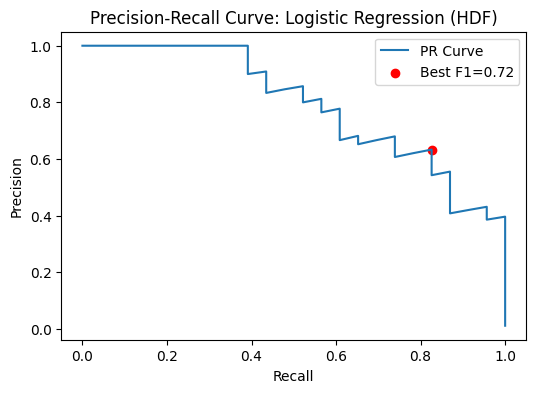

  Model: Decision Tree


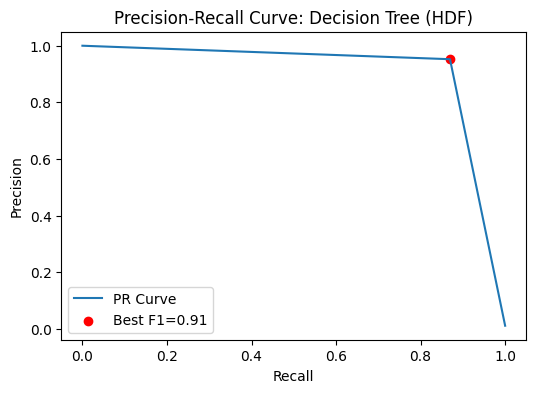

  Model: Random Forest


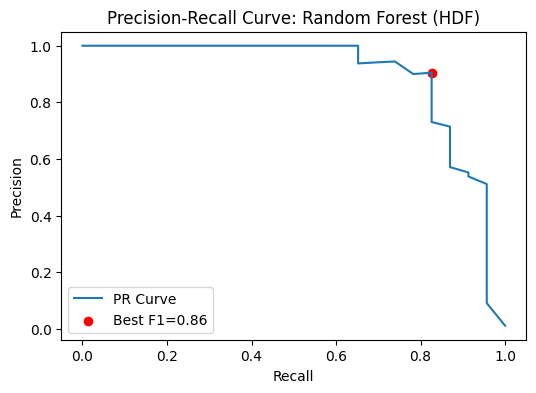


=== Failure Type: PWF ===
  Model: Logistic Regression


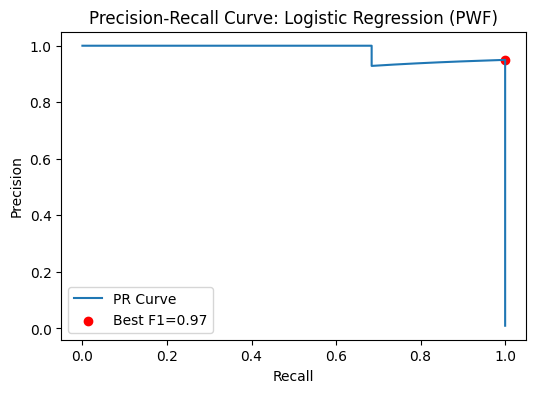

  Model: Decision Tree


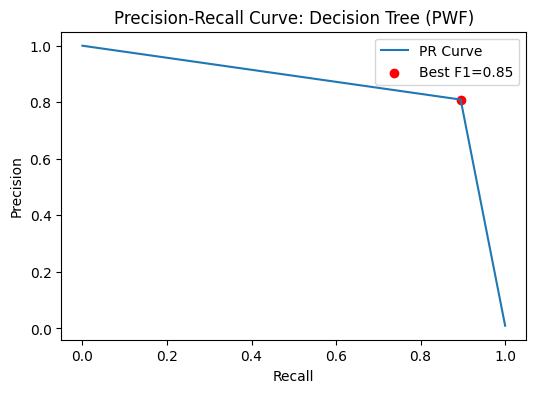

  Model: Random Forest


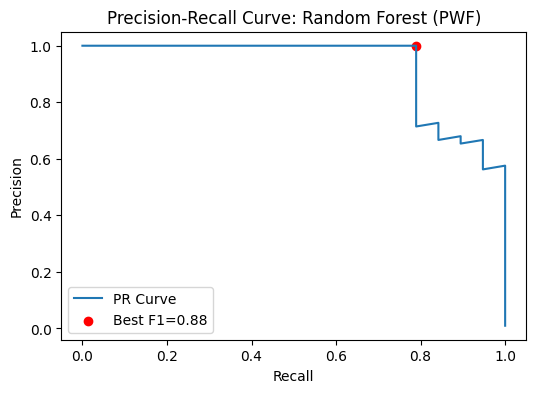


=== Failure Type: OSF ===
  Model: Logistic Regression


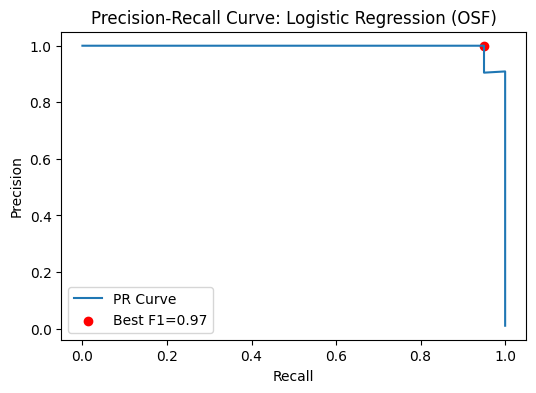

  Model: Decision Tree


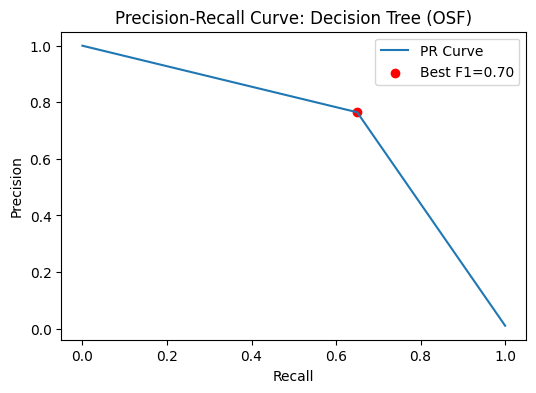

  Model: Random Forest


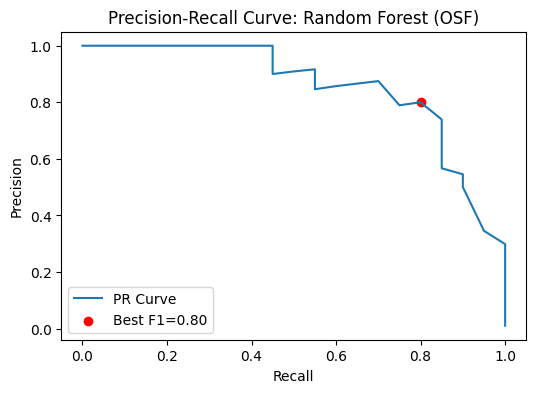


=== Failure Type: RNF ===
  Model: Logistic Regression


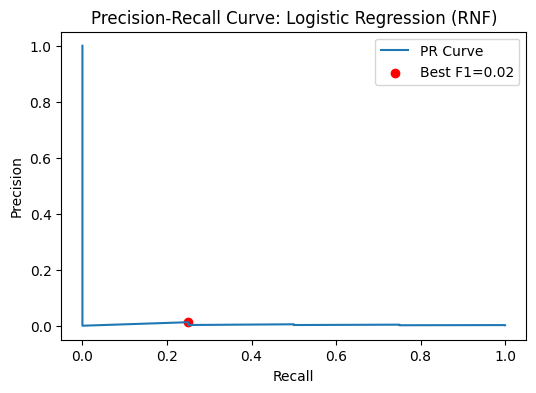

  Model: Decision Tree


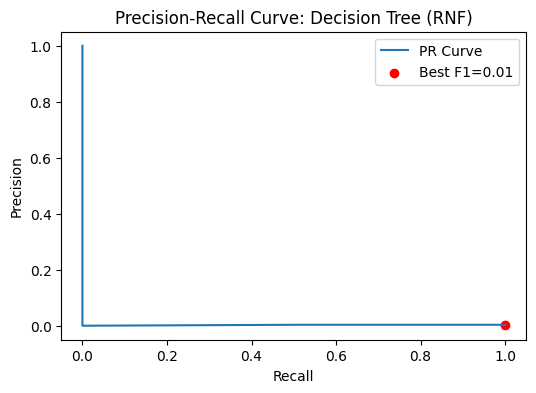

  Model: Random Forest


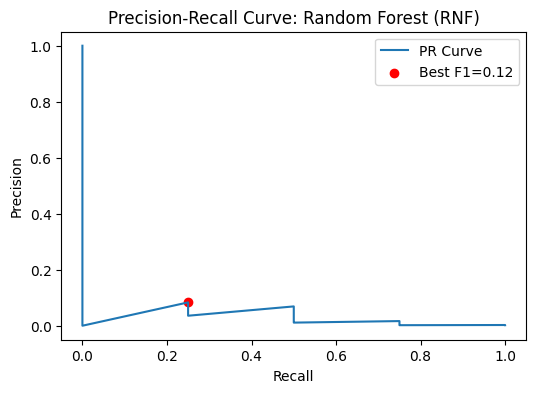

,Failure Type,Model,Best Params,Best Threshold,F1 (Best Thresh),Precision (Best Thresh),Recall (Best Thresh),F1 (0.5 Thresh),Precision (0.5 Thresh),Recall (0.5 Thresh)
0,Machine failure,Logistic Regression,"{'C': 1, 'penalty': 'l2'}",0.208521,0.500000,0.486111,0.514706,0.240964,0.666667,0.147059
1,Machine failure,Decision Tree,"{'max_depth': 10, 'min_samples_split': 5}",0.866667,0.766667,0.884615,0.676471,0.740157,0.796610,0.691176
2,Machine failure,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.340000,0.753846,0.790323,0.720588,0.672727,0.880952,0.544118
3,TWF,Logistic Regression,"{'C': 1, 'penalty': 'l2'}",0.090245,0.230769,0.176471,0.333333,0.000000,0.000000,0.000000
4,TWF,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",0.000000,0.008960,0.004500,1.000000,0.000000,0.000000,0.000000
5,TWF,Random Forest,"{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.029970,0.117647,0.065789,0.555556,0.000000,0.000000,0.000000
6,HDF,Logistic Regression,"{'C': 10, 'penalty': 'l2'}",0.192627,0.716981,0.633333,0.826087,0.611111,0.846154,0.478261
7,HDF,Decision Tree,"{'max_depth': None, 'min_samples_split': 2}",1.000000,0.909091,0.952381,0.869565,0.909091,0.952381,0.869565
8,HDF,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.270000,0.863636,0.904762,0.826087,0.685714,1.000000,0.521739
9,PWF,Logistic Regression,"{'C': 1, 'penalty': 'l1'}",0.438756,0.974359,0.950000,1.000000,0.857143,0.937500,0.789474


In [4]:
# Advanced Model Tuning: GridSearchCV, Threshold Tuning, and Results Collection

results = []
models, param_grids = get_model_param_grids()

for failure in FAILURE_TYPES:
    print(f'\n=== Failure Type: {failure} ===')
    # Prepare data
    X = df_clean.drop(FAILURE_TYPES, axis=1)
    y = df_clean[failure]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    for model_name, model in models.items():
        print(f'  Model: {model_name}')
        grid = run_grid_search(model, param_grids[model_name], X_train, y_train)
        best_model = grid.best_estimator_
        # Predict probabilities for threshold tuning
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)[:,1]
        else:
            y_proba = best_model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        # Find best threshold for F1-score (class 1)
        best_thresh, best_f1, best_prec, best_rec = find_best_threshold(y_test, y_proba)
        # Predict with best threshold
        y_pred = (y_proba >= best_thresh).astype(int)
        # Collect metrics
        results.append({
            'Failure Type': failure,
            'Model': model_name,
            'Best Params': grid.best_params_,
            'Best Threshold': best_thresh,
            'F1 (Best Thresh)': best_f1,
            'Precision (Best Thresh)': best_prec,
            'Recall (Best Thresh)': best_rec,
            'F1 (0.5 Thresh)': f1_score(y_test, (y_proba >= 0.5).astype(int)),
            'Precision (0.5 Thresh)': precision_score(y_test, (y_proba >= 0.5).astype(int)),
            'Recall (0.5 Thresh)': recall_score(y_test, (y_proba >= 0.5).astype(int)),
        })
        # Plot precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(recalls, precisions, label='PR Curve')
        plt.scatter([best_rec], [best_prec], color='red', label=f'Best F1={best_f1:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve: {model_name} ({failure})')
        plt.legend()
        plt.show()

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
display(results_df)


Model,Decision Tree,Logistic Regression,Random Forest
Failure Type,,,
HDF,0.909091,0.716981,0.863636
Machine failure,0.766667,0.500000,0.753846
OSF,0.702703,0.974359,0.800000
PWF,0.850000,0.974359,0.882353
RNF,0.006803,0.023810,0.125000
TWF,0.008960,0.230769,0.117647


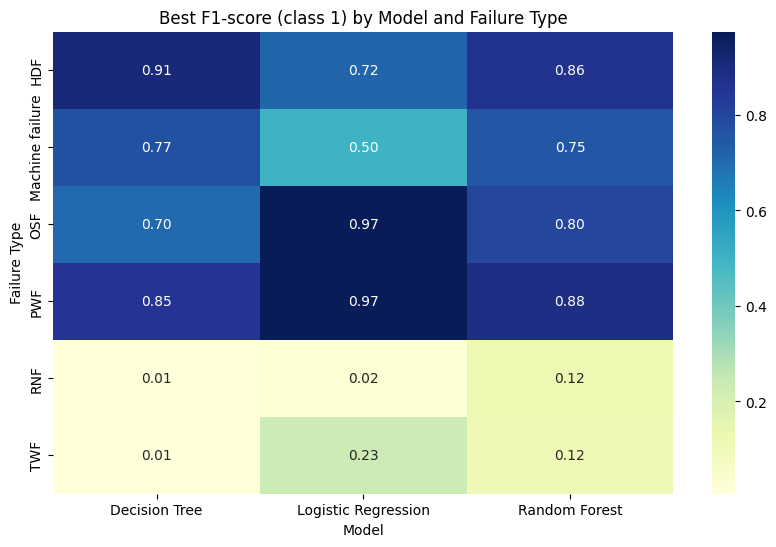

Results exported to advanced_tuning_results.csv


In [5]:
# Summarize, Visualize, and Export Advanced Tuning Results

# Show best F1-score (class 1) per failure type/model
pivot_f1 = results_df.pivot(index='Failure Type', columns='Model', values='F1 (Best Thresh)')
display(pivot_f1)

# Visualize F1-score (class 1) for each model/failure type
plt.figure(figsize=(10,6))
sns.heatmap(pivot_f1, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Best F1-score (class 1) by Model and Failure Type')
plt.show()

# Export results to CSV for sharing
results_df.to_csv('advanced_tuning_results.csv', index=False)
print('Results exported to advanced_tuning_results.csv')

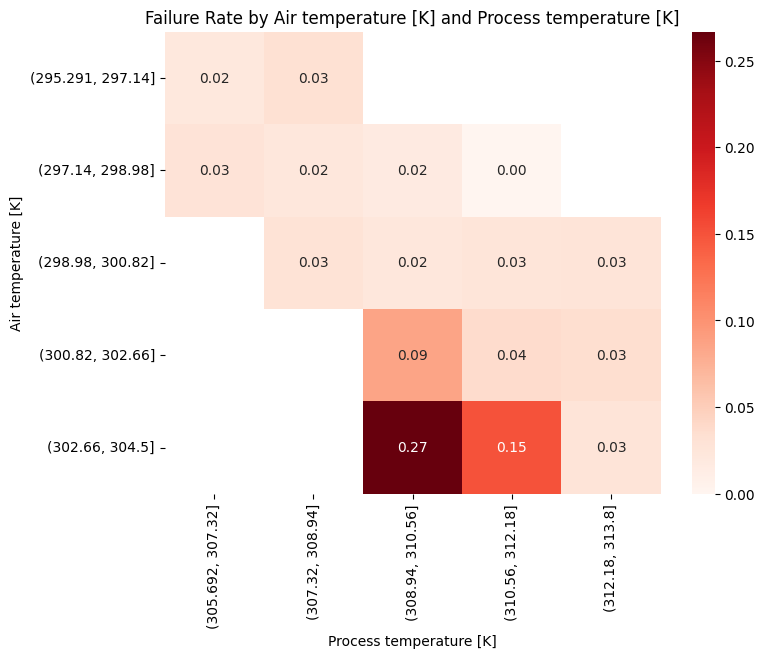

In [6]:
# Choose two process parameters, e.g., 'Air temperature [K]' and 'Process temperature [K]'
param1 = 'Air temperature [K]'
param2 = 'Process temperature [K]'
failure_col = 'Machine failure'  # or any specific failure type

# Bin both parameters
df_clean['param1_bin'] = pd.cut(df_clean[param1], bins=5)
df_clean['param2_bin'] = pd.cut(df_clean[param2], bins=5)

# Pivot table: failure rate for each combination
pivot = df_clean.pivot_table(
    index='param1_bin',
    columns='param2_bin',
    values=failure_col,
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title(f'Failure Rate by {param1} and {param2}')
plt.xlabel(param2)
plt.ylabel(param1)
plt.show()


=== Feature Importance for Machine failure (Random Forest) ===


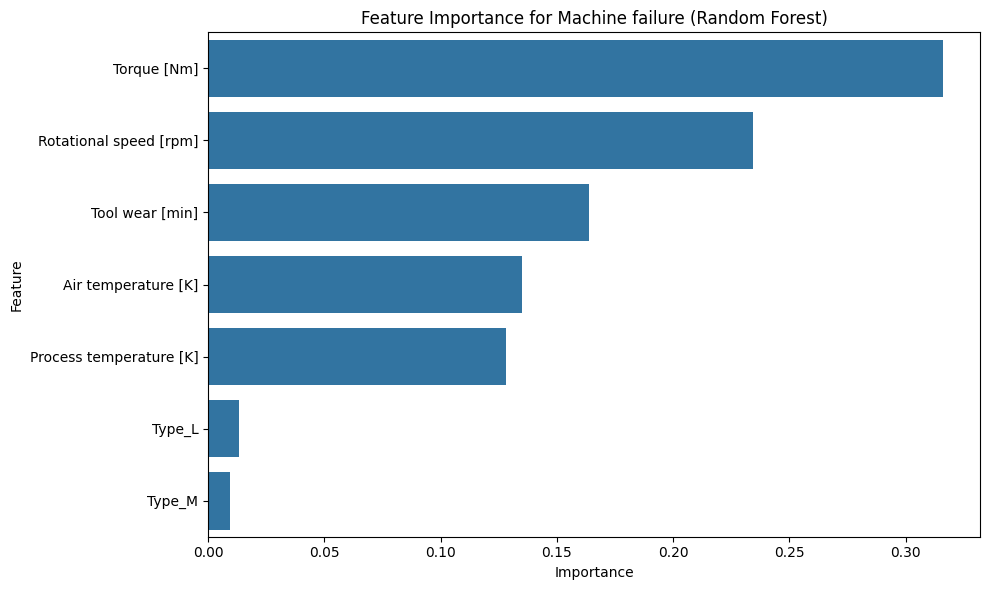


=== Feature Importance for TWF (Random Forest) ===


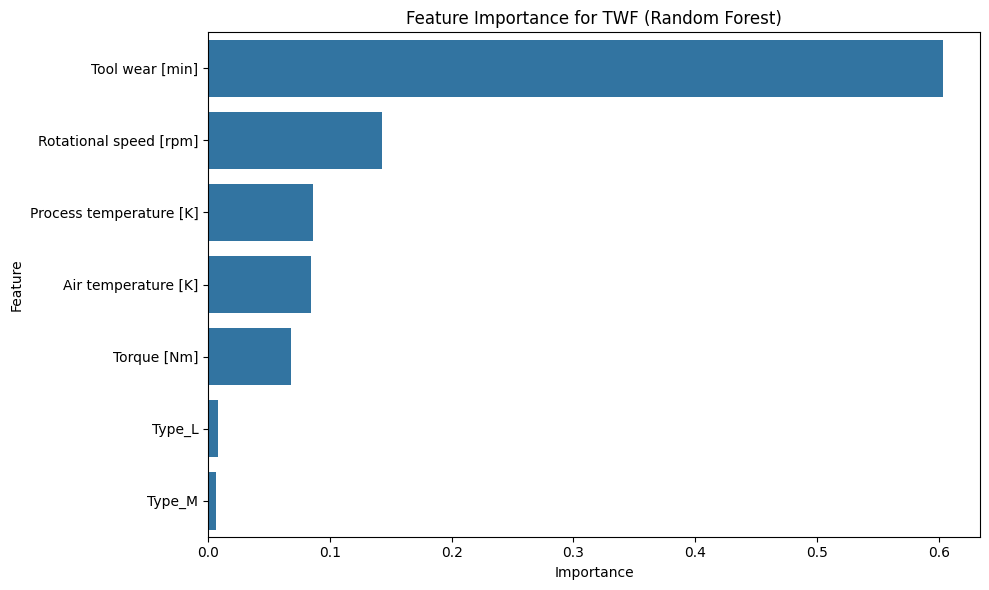


=== Feature Importance for HDF (Random Forest) ===


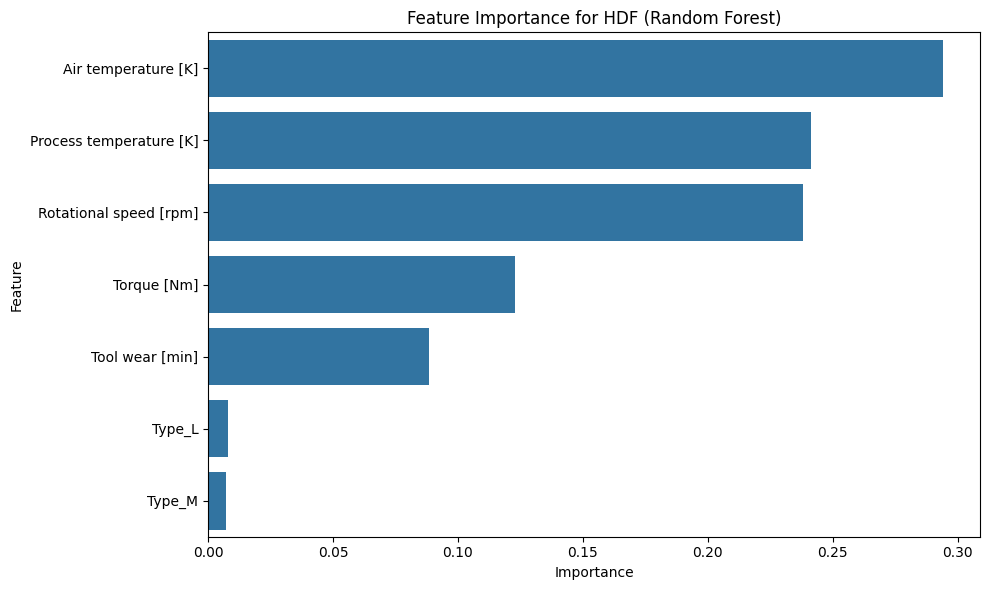


=== Feature Importance for PWF (Random Forest) ===


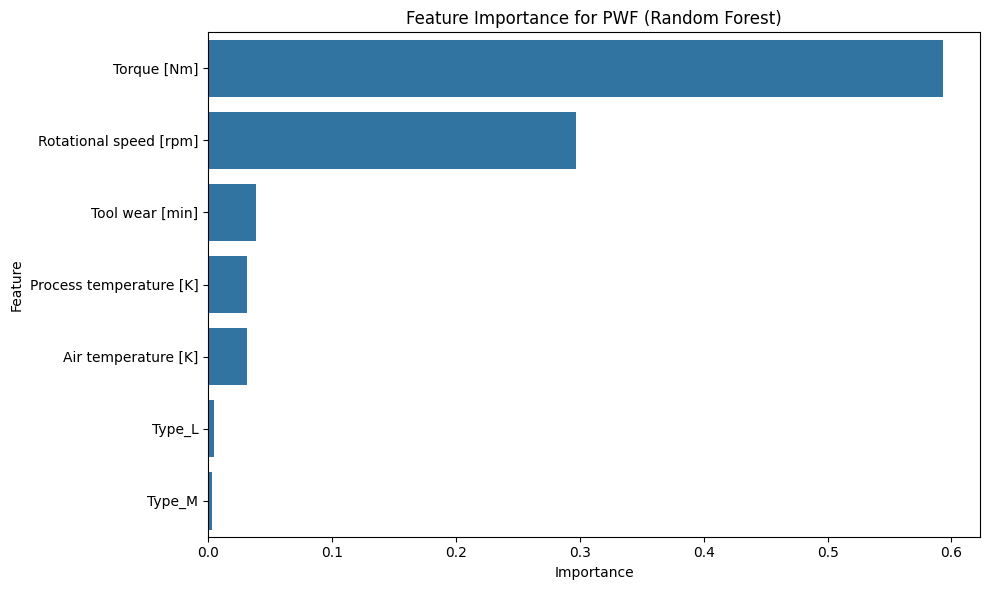


=== Feature Importance for OSF (Random Forest) ===


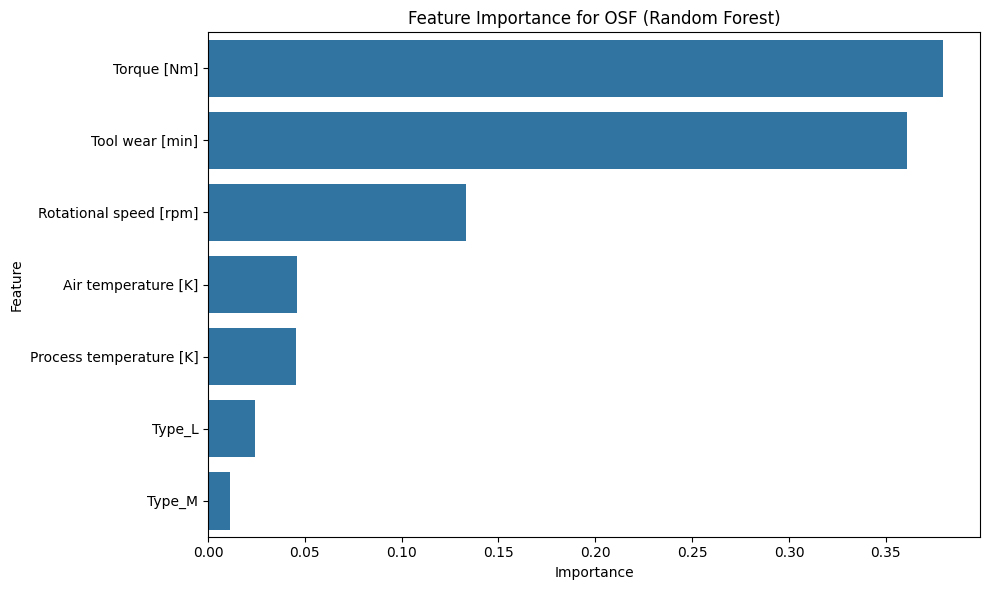


=== Feature Importance for RNF (Random Forest) ===


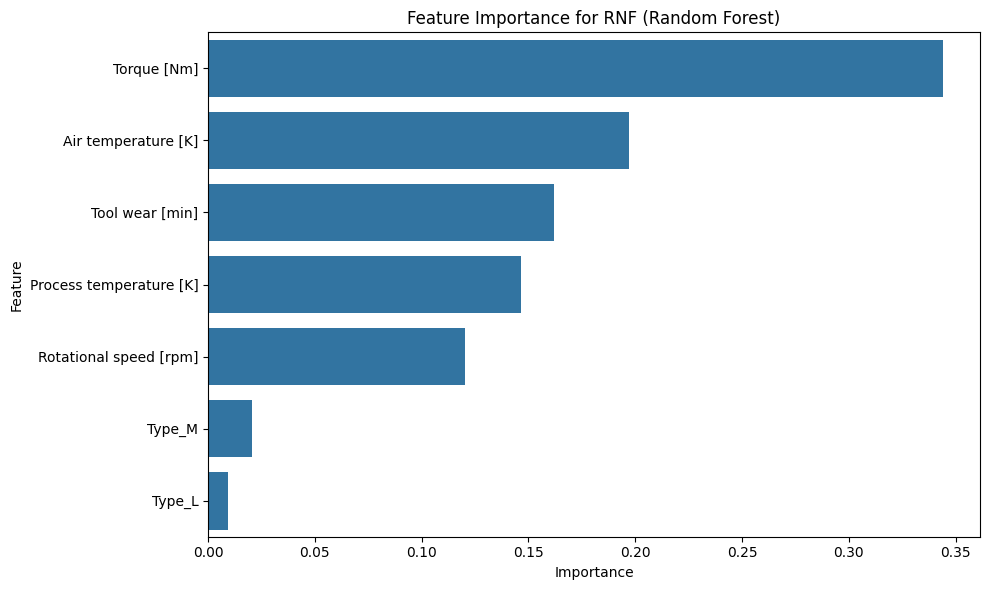

In [12]:
# Feature Importance for Each Failure Type (Random Forest)
import ast

for failure in FAILURE_TYPES:
    print(f'\n=== Feature Importance for {failure} (Random Forest) ===')
    # Prepare data
    X = df_clean.drop(FAILURE_TYPES, axis=1)
    # Drop columns with Interval dtype or bin columns
    X = X.loc[:, ~X.columns.str.contains('Bin', case=False)]
    for col in X.columns:
        if pd.api.types.is_interval_dtype(X[col]):
            X = X.drop(columns=[col])
    y = df_clean[failure]
    # Get best params for Random Forest from results_df
    rf_row = results_df[(results_df['Failure Type'] == failure) & (results_df['Model'] == 'Random Forest')]
    if rf_row.empty:
        print(f'No Random Forest results for {failure}. Skipping.')
        continue
    best_params = rf_row['Best Params'].iloc[0]
    # If best_params is a string (e.g., from CSV), convert to dict
    if isinstance(best_params, str):
        try:
            best_params = ast.literal_eval(best_params)
        except Exception as e:
            print(f'Could not parse best_params for {failure}: {e}')
            continue
    try:
        rf = RandomForestClassifier(**best_params)
        rf.fit(X, y)
        # Get and plot feature importances
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x=importances.values, y=importances.index)
        plt.title(f'Feature Importance for {failure} (Random Forest)')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Error fitting Random Forest for {failure}: {e}')